# Deep Learning Models

### Long short-term memory (LSTM)

LSTM is being used instead of ANN for classification (fake or real news) because it's based on RNN deep neural network and have capability of learning order dependence in sequence prediction problems. Learning such skills is crucial for tackling challenging issues like automated translation and speech recognition.
.

## System Resources

The most challenging part was to ensure having a significant amount of resource even for using `ZeroShotClassifier` and `FewShotClassifier` with a model having less paramaters (1 Billion). Therefore, i have selected the Google Colab envoirnment to Train the classifier using GPU `A100` and `V100` and original data is trimmed to lowers numbers to get the results at the earlier and to reduce the cost. This will be further discuss in the sections below.

## Importing the Required Libraries

Downloading the required libraries for the LLM training

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, train_test_split

#Deep learning libraries
import keras
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Dropout

# Displaying Lobraries
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

# Loading datasets and Splitting

### 1. Loading the dataset

Cleaned data extratced after preprocessing the text is loaded for the purpose of neural deep LSTM based model.</p>

In [8]:
cleaned_df = pd.read_csv('cleaned_data.csv')

In [9]:
cleaned_df

,label,title_text
0,true,national federation independent business
1,true,comment fayetteville nc
2,true,romney make pitch hope close deal election roc...
3,true,democratic leader say house democrats united g...
4,true,budget united states government fy
...,...,...
60731,fake,white house theatrics gun control 21st century...
60732,fake,activist terrorist medium control dictate narr...
60733,fake,boiler room surrender retreat head roll ep tun...
60734,fake,federal showdown looms oregon blm abuse local ...


In [10]:
cleaned_df['title_text'] = cleaned_df['title_text'].astype(str)

## Split data into Training and Testing [Training: 80%, Testing:20%]

 Dataset is splitted into X_train, X_test, y_train, y_test using Sk-Learn library with the ratio 80% - Training and 20% Testing.</p>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['title_text'], cleaned_df['label'], test_size=0.2, shuffle=True, random_state=42)

# General OverView - Polarity, News Text Length and Word Count

<p style="color:#45b6fe"><b style="color:lightgreen"></b> Though, the overview of the new text has already perfromed during feature presentation and dataset outlook section. However, This is reproduced here for the reference purposes to identify Vocabulory size and sentence for one-hot encoding and embedding the documents (News Text). </p>

In [15]:
# Checking the polarity (Ranges between -1 and 1) of the title_text based on the sentiment attribute in "TextBlob".
cleaned_df['polarity'] = cleaned_df['title_text'].map(lambda text: TextBlob(text).sentiment.polarity)
cleaned_df['text_length'] = cleaned_df['title_text'].astype(str).apply(len)
cleaned_df['word_count'] = cleaned_df['title_text'].apply(lambda x: len(str(x).split()))

/var/folders/th/dphkt_6d7wx8n0_g8ybhgrsw0000gn/T/ipykernel_1362/2619088714.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
/var/folders/th/dphkt_6d7wx8n0_g8ybhgrsw0000gn/T/ipykernel_1362/2619088714.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cleaned_df['polarity'])
/var/folders/th/dphkt_6d7wx8n0_g8ybhgrsw0000gn/T/ipykernel_1362/2619088714.py:8: UserWarning: 

`distplot` 

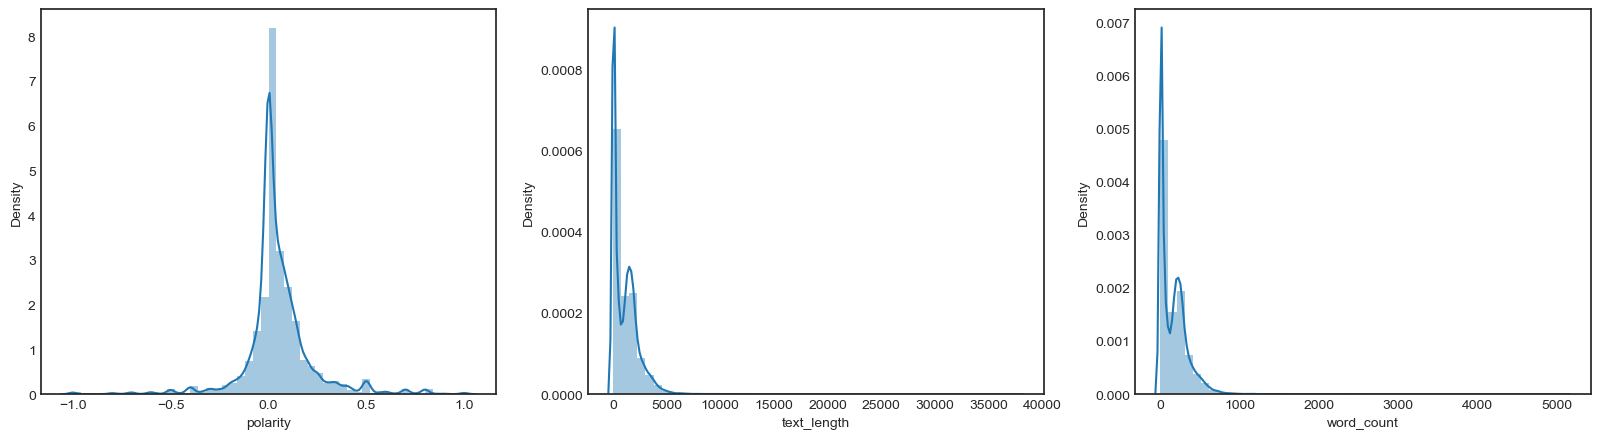

In [16]:
#Plotting the distribution based on the extracted features
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(cleaned_df['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(cleaned_df['text_length'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(cleaned_df['word_count'])
fig = plt.gcf()



*   We can notice that most articles has polarity of almost 0 neither being sad nor happy.
*   Text length for the news is around 0-5000 characters.
*   Wrod count is in between 0-1000 words.



# One-Hot Encoding

One-hot encoding in NLP is used to categorize the textual data as dense vectors to be processed by the neural networks. Words in NLP being categorical variables are expensive to process, therefore, one-hot encoding is used to represent these words into dense, continuous vectors (embeddings) by having a binary vector of the same length as vocabulary size.


In [17]:
#Vocabulary size is set to 7000 words because maximum text length is around 5000 based on text_length plot
voc_size=7000

#One hot encoding using tensor flow keras module to news text into numerical vectors
onehot_repr=[one_hot(words,voc_size)for words in cleaned_df['title_text']]

In [18]:
onehot_repr[0:10]

[[6264, 272, 4196, 4706],
 [298, 6951, 2729],
 [2134, 4602, 5337, 3410, 3701, 1664, 1598, 1963, 4089, 6190],
 [1129, 6681, 4979, 5570, 6194, 5324, 4252, 1661, 6282],
 [806, 5324, 4609, 5974, 4454],
 [4263, 6987, 686, 4979, 5273, 3556, 2116, 6264, 1596, 4052],
 [332, 454],
 [5017, 1991],
 [6606, 6017, 5570, 1352, 6872, 327, 5702],
 [4574, 5808, 453, 994, 2954]]

We can notice that all the text is converetd into index for the vocabulary created

# Padding the documents

The second step in implementation is to perform the padding of documents. Padding of the text is required to have a fixed length of tokens. This is fundamental for the neural network to have inputs for fixed size because textual data could be shorter or longer. Tensor flow Keras pad_sequence is used to perform the padding for neural network and sequence is kept as `pre` to ensure `zero's` is added at the beginning. Benefit of using `pre` are as follows:
*   Preserving the contextual information by keeping words towards the end in order for the model to capture the meaningful context.
*   It provides the compatibility with the right to left languages, such as Arabic or Urdu.
*   It gives the fixed length inputs for the vectors for model to process.
*   It ensures consistency and simplicity for different layers of the models, such as embedding layer and convolution layer.





In [19]:
#Fixed sentence length to be padded or truncated in order to have a length of 5000 tokens.
sent_length=5000

# Padding the sequences of one-hot encoded vectors
# Pre is provided to esnure padding (or truncating) [Zeros] is added to the beginning of each sequence.
# This ensures that the actual content of the sentence is closer to the end
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)



[[   0    0    0 ...  272 4196 4706]
 [   0    0    0 ...  298 6951 2729]
 [   0    0    0 ... 1963 4089 6190]
 ...
 [   0    0    0 ... 3507 2649 5767]
 [   0    0    0 ... 1838 6247 2424]
 [   0    0    0 ... 5407 3204  286]]


# Long short-term memory (LSTM) Model

Now we can performed the sequential model network for classification of news between `true` or `fake`. This will be achieved using keras with tensor flow backend having below mentioned layers:

1.   Embedding layer having embedding vector features to have a dense vector of 40 [40-Dimentional vector space]. This could be adjusted based on hyperparameter tuning and adopting experimental approach.
2.   First Drop-out  for the regularization to avoid the overfitting, which could be occured by models during the trianing or inference phase.
3.   LSTM layer for the sequence modeling.
4.   Second Drop-out layer for the regularization.
5.   Final Dense Layer with activation function Sigmoid used for the binary classification tasks.

`Input (Word indices) --> Embedding Layer --> Dropout --> LSTM --> Dropout --> Dense (Sigmoid)`




In [20]:
# Number of Dimensions for the word embeddings
embedding_vector_features=40
# Initializing the sequential model
model=Sequential()
# adding the embedding layer
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
# First Dropout layer for the regularization with rate of 0.3
model.add(Dropout(0.3))
#Adding 100 lstm neurons in the layer
model.add(LSTM(100))
# Second Dropout layer for the regularization with rate of 0.3
model.add(Dropout(0.3))
# Fully connected dense layer with activation function 'sigmoid' for binary classifcation.
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

2023-08-12 10:15:50.946809: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-12 10:15:50.946838: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-12 10:15:50.946842: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-12 10:15:50.946911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-12 10:15:50.946947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          280000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 336501 (1.28 MB)
Trainable params: 336501 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [21]:
# Embedding are based on the text and label are taken directly from the dataframe (cleaned_df). Both have similar length in numbers.
# For a binary classification task, the shape of cleaned_df['label'] as (60737,), indicating that you have there are 60737 binary labels (0s and 1s).
len(embedded_docs),cleaned_df['label'].shape

(60736, (60736,))

### Fitting the model

Fitting the model into Numpy Array for the model fitting.

In [22]:
# Converting the embedded documents [List of one hot encoded vectors] and labels as array before fitting into the models
X_final=np.array(embedded_docs)
# labels (true and fake) are converted into 0 and 1 before fitting into model as it only expects numerical values
y_final = np.array(cleaned_df['label'].replace({'true': 1, 'fake': 0}))

#Check shape of X [text] and y[label] as final array
X_final.shape,y_final.shape

((60736, 5000), (60736,))

#### First Run [epochs=10 and batch size=64]

In [29]:
# Splitting the final data into X_train, X_test, y_train and y_test for model fitting
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
760/760 [==============================] - 270s 344ms/step - loss: 0.3315 - accuracy: 0.8628 - val_loss: 0.2272 - val_accuracy: 0.9058
Epoch 2/10
760/760 [==============================] - 195s 256ms/step - loss: 0.2185 - accuracy: 0.9101 - val_loss: 0.2465 - val_accuracy: 0.8976
Epoch 3/10
760/760 [==============================] - 174s 229ms/step - loss: 0.1750 - accuracy: 0.9285 - val_loss: 0.2419 - val_accuracy: 0.9037
Epoch 4/10
760/760 [==============================] - 165s 217ms/step - loss: 0.2091 - accuracy: 0.9129 - val_loss: 0.2373 - val_accuracy: 0.9040
Epoch 5/10
760/760 [==============================] - 161s 212ms/step - loss: 0.1601 - accuracy: 0.9354 - val_loss: 0.2454 - val_accuracy: 0.9043
Epoch 6/10
760/760 [==============================] - 162s 213ms/step - loss: 0.1685 - accuracy: 0.9319 - val_loss: 0.2353 - val_accuracy: 0.9060
Epoch 7/10
760/760 [==============================] - 158s 207ms/step - loss: 0.1393 - accuracy: 0.9448 - val_loss: 0.2259 -

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting from test data
y_pred=model.predict(X_test)

380/380 [==============================] - 26s 68ms/step


<Figure size 1500x1500 with 0 Axes>

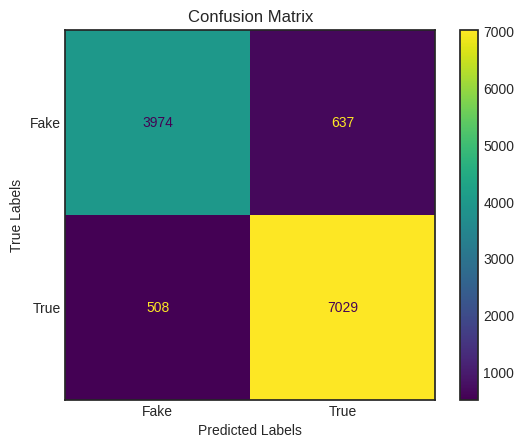

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Round the predicted probabilities to get predicted classes (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display labels
display_labels = ['Fake', 'True']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
plt.gcf().set_size_inches(15, 15)
disp.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9057458017780705

In [41]:
from sklearn.metrics import classification_report

print("Classification Report:\n",classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      4611
           1       0.92      0.93      0.92      7537

    accuracy                           0.91     12148
   macro avg       0.90      0.90      0.90     12148
weighted avg       0.91      0.91      0.91     12148



In [25]:
# Splitting the final data into X_train, X_test, y_train and y_test for model fitting
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64)

Epoch 1/15


2023-08-12 10:16:00.163206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 10:16:00.781642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 10:16:02.437924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


760/760 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.8781

2023-08-12 10:25:05.784348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 10:25:05.868147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


760/760 [==============================] - 574s 751ms/step - loss: 0.2909 - accuracy: 0.8781 - val_loss: 0.2175 - val_accuracy: 0.9127
Epoch 2/15
760/760 [==============================] - 2041s 3s/step - loss: 0.2159 - accuracy: 0.9111 - val_loss: 0.2223 - val_accuracy: 0.9089
Epoch 3/15
760/760 [==============================] - 554s 728ms/step - loss: 0.2439 - accuracy: 0.9058 - val_loss: 0.2445 - val_accuracy: 0.9024
Epoch 4/15
760/760 [==============================] - 553s 727ms/step - loss: 0.1906 - accuracy: 0.9223 - val_loss: 0.2224 - val_accuracy: 0.9133
Epoch 5/15
760/760 [==============================] - 563s 740ms/step - loss: 0.2678 - accuracy: 0.8899 - val_loss: 0.3109 - val_accuracy: 0.8676
Epoch 6/15
760/760 [==============================] - 559s 736ms/step - loss: 0.2402 - accuracy: 0.9035 - val_loss: 0.2394 - val_accuracy: 0.9002
Epoch 7/15
760/760 [==============================] - 554s 729ms/step - loss: 0.1828 - accuracy: 0.9273 - val_loss: 0.2459 - val_accuracy

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting from test data
y_pred=model.predict(X_test)

2023-08-12 13:02:07.746390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 13:02:07.944695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


380/380 [==============================] - 47s 123ms/step


<Figure size 1500x1500 with 0 Axes>

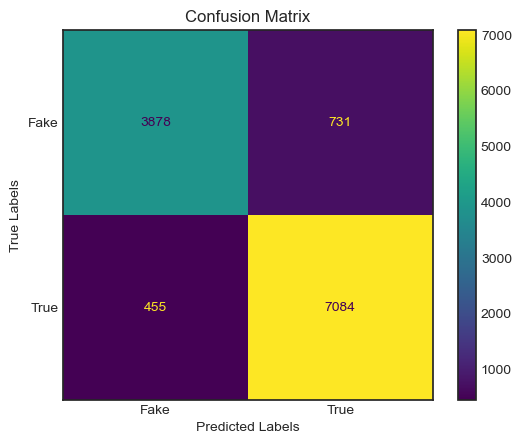

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Round the predicted probabilities to get predicted classes (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display labels
display_labels = ['Fake', 'True']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
plt.gcf().set_size_inches(15, 15)
disp.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.902370760619032

In [29]:
from sklearn.metrics import classification_report

print("Classification Report:\n",classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87      4609
           1       0.91      0.94      0.92      7539

    accuracy                           0.90     12148
   macro avg       0.90      0.89      0.90     12148
weighted avg       0.90      0.90      0.90     12148



In [30]:
# Splitting the final data into X_train, X_test, y_train and y_test for model fitting
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=32)

Epoch 1/10
1519/1519 [==============================] - 873s 574ms/step - loss: 0.1478 - accuracy: 0.9436 - val_loss: 0.2469 - val_accuracy: 0.9076
Epoch 2/10
1519/1519 [==============================] - 900s 592ms/step - loss: 0.1153 - accuracy: 0.9561 - val_loss: 0.2408 - val_accuracy: 0.9124
Epoch 3/10
1519/1519 [==============================] - 898s 591ms/step - loss: 0.1062 - accuracy: 0.9585 - val_loss: 0.2488 - val_accuracy: 0.9100
Epoch 4/10
1519/1519 [==============================] - 955s 629ms/step - loss: 0.0814 - accuracy: 0.9683 - val_loss: 0.2328 - val_accuracy: 0.9197
Epoch 5/10
1519/1519 [==============================] - 1050s 691ms/step - loss: 0.0689 - accuracy: 0.9734 - val_loss: 0.2578 - val_accuracy: 0.9202
Epoch 6/10
1519/1519 [==============================] - 1177s 775ms/step - loss: 0.0622 - accuracy: 0.9758 - val_loss: 0.2682 - val_accuracy: 0.9153
Epoch 7/10
1519/1519 [==============================] - 1339s 881ms/step - loss: 0.0549 - accuracy: 0.9786 - v

In [2]:
#save the tensorflow model
model.save('model.h5')

NameError: name 'model' is not defined

In [ ]:
# Predicting from test data
y_pred=model.predict(X_test)

In [ ]:
#Checking the accuracy of the model on the test set
accuracy_score(y_test,y_pred)

In [ ]:
print("Classification Report:\n",classification_report(y_test, y_pred))

**Conclusion :** We can clearly notice that probabilies are quite low by our model. This might be because `bloomz-1b1` might not have been trained on classification task espcially fake news. `ZeroShotClassifier` and `FewShotClassifer` heavily relies on the pre trained data quality, therefore, there is possibility that it might not run on low level distiction between different categories.

We can cross validation by the above outcome by using Skorch builtin method `error_low_prob`.

**Next Step :** It is now confirmed that the `bloomz-1b1` is not the right model for classification task especially for `real` and `fake`. Though, `ZeroShotClassifier` and `FewShotClassifer` have its own benefits such as:

*   It can work on the unseen data based using pre trained models.
*   Reduced the need for re training or fine tunining with respect to relationship between different classes or categories
*   Easy to scale as it can handle wide range of inputs.

However, It only depends on the model you are usuing. We have clearly confirmed from our analysis that `bloomz-1b1` is not the right model even though it is trained over 1 billion parameters. One possible solution is to try other low paramters models using `ZeroShotClassifier` and `FewShotClassifer` with the help of `GridCVSearch`. However, this will be resource hungry task and we might not get the desired results. Therefore, Next step in my journey of identifying best working model for fake news classification is as follows:

1.   FineTune LLM for classification task and select the model that perfromed well for fake news classification task. Best performing model could be easily identifed from research papers already analysed.
2.   Develop fake news classifier using using Long Short Term Memory (LSTM).
3.   Develop Standard machine learning solution using classical supervised machine learning approach (Baseline Approaches).





